In [ ]:
# Important, set your home directory here:
home_dir = ''


In [ ]:
import os
os.chdir(home_dir)

import numpy as np
import pandas as pd

import lightgbm as lgb
from scipy.interpolate import interp1d
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
%load_ext autoreload
%autoreload 2
from main.models.utils import cv_early_stopping
from main.fairness.paramfitter import LocationScaleEMDW1,BetaEMWD
from main.fairness.wasserstein import WassersteinBinary
from main.loaders.loader_compas import prepare_compas, load_compas
from main.loaders.loader_pubcov import load_coverage_data, prepare_pubcov
from main.fairness.metrics import unfairness
from main.evaluation.evaluator import get_metrics


# Calculations Compas

In [ ]:
check_frame = load_compas('../parametric_fairness/data/compas/compas-scores-two-years.csv')

drop_features = ['two_year_recid',
                 'event',
                 'id',
                 'name',
                 'first',
                 'last', 
                 'compas_screening_date',
                 'dob',
                 'c_jail_in',
                 'c_jail_out', 
                 'c_case_number',
                 'age', # Exclude age to enable cats
                 'priors_count',
                 'priors_count.1',
                 'screening_date', 
                 'v_type_of_assessment',
                 'v_screening_date',
                 'in_custody', 
                 'out_custody',
                 'start', 
                  'end',
                 'decile_score',
                 'decile_score.1', 
                 'score_text',
                 'v_decile_score',
                 'target_high', 
                 ]


In [ ]:
X_train, X_test, y_train, y_test, transformer = prepare_compas(drop_list=drop_features,
                                                               target='is_violent_recid')

In [ ]:
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

X_train = np.delete(X_train, 2, axis=1)
X_train = np.delete(X_train, 1, axis=1)
X_train = np.delete(X_train, 0, axis=1)

X_test = np.delete(X_test, 2, axis=1)
X_test = np.delete(X_test, 1, axis=1)
X_test = np.delete(X_test, 0, axis=1)

In [ ]:
params = {
    "objective": "binary",
    "metric": "auc",
    "min_data_in_leaf": 10,
    "learning_rate": 0.01,
    "verbose": -1
}

cv_results = cv_early_stopping(params=params, 
                               nfolds=3, 
                               max_rounds=1000, 
                               early_stopping_rounds=50, 
                               X_train=X_train, 
                               y_train=y_train, 
                               objective='classification')


best_res = np.argmax(cv_results['metric'])
best_iter = cv_results['iterations'][best_res]
print(best_iter)


# Re-Train on whole dataset
data_train_all = lgb.Dataset(data=X_train, 
                             label=y_train)

best_estimator = lgb.train(params=params,
                           train_set=data_train_all, 
                           num_boost_round=best_iter)


preds_uncorrected_calib = best_estimator.predict(X_train)
preds_uncorrected_test = best_estimator.predict(X_test)

In [ ]:
sens_observed_calib = np.where(X_train_orig[:, 0] > 0, 1, 0)
sens_observed_test = np.where(X_test_orig[:, 0] > 0,1,0) 
sens_unobserved_test = np.where(X_test_orig[:,1] > 0,1,0) 

param_samp = LocationScaleEMDW1()

metrics, nonparam, param, sampler = get_metrics(param_samp,
                                                preds_uncorrected_calib,
                                                preds_uncorrected_test,
                                                sens_observed_calib,
                                                sens_observed_test,
                                                sens_unobserved_test, 
                                                y_test, 
                                                mc_len=10, 
                                                min_glob=0)

In [ ]:
export_df = pd.DataFrame({
    'group': "density of $g^{*(fair)}$", 
    'subgroup': np.where(sens_unobserved_test == 1, 'subgroup', np.nan),
    'parametric': 'Non-parametric',
    'value': nonparam
})

export_df.to_csv('data/example_data/export_nonparam_compas.csv', index=False)

export_df = pd.DataFrame({
    'group': "density of $g^{*(fair)}$", 
    'subgroup': np.where(sens_unobserved_test == 1, 'subgroup', np.nan),
    'parametric': 'Parametric',
    'value': param
})

export_df.to_csv('data/example_data/export_param_compas.csv', index=False)

# Calculations Folktabs

In [ ]:
data_red = load_coverage_data()

# Create target variable
data_red.loc[:, 'PUBCOV'] = np.where(data_red['PUBCOV'] == 1, 1, 0)
data_red = data_red.assign(low_dummy=np.where(data_red['PINCP'] < 45000, 1, 0))
data_red = data_red.assign(very_low_dummy=np.where(data_red['PINCP'] < 15000, 1, 0))
# Drop column with info
data_red = data_red.drop(columns=['PINCP'])

X_train, X_test, y_train, y_test, transformer = prepare_pubcov(data_red, 
                                                                seed=42)

# Keep set of original splits (makes it easier to recover
# the orignal variable later on)
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

X_train = np.delete(X_train, 23, axis=1)
X_test = np.delete(X_test, 23, axis=1)
        
# Model optimization
# Fit a basic model
params = {
    "objective": "binary",
    "metric": "auc",
    "min_data_in_leaf": 50,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "verbose": -1
}

cv_results = cv_early_stopping(params=params, 
                            nfolds=3, 
                            max_rounds=1000, 
                            early_stopping_rounds=20, 
                            X_train=X_train, 
                            y_train=y_train, 
                            objective='classification')


# Fit best model (based on boosting iters)
best_res = np.argmax(cv_results['metric'])
best_iter = cv_results['iterations'][best_res]

# Re-Train on whole dataset
data_train_all = lgb.Dataset(data=X_train, 
                            label=y_train)

best_estimator = lgb.train(params=params,
                        train_set=data_train_all, 
                        num_boost_round=best_iter)

# Run predictions
preds_uncorrected_calib = best_estimator.predict(X_train)
preds_uncorrected_test = best_estimator.predict(X_test)

# Recover full set of sensitive variables
# and set to sensitive variables
# Here: 22
sens_observed_calib = np.where(X_train_orig[:, 22] > 0, 1, 0)
sens_observed_test = np.where(X_test_orig[:, 22] > 0,1,0) 
sens_unobserved_test = np.where(X_test_orig[:,23] > 0,1,0)

# Use a beta model
preds_uncorrected_calib = best_estimator.predict(X_train)
preds_uncorrected_test = best_estimator.predict(X_test)

fairness_trans = WassersteinBinary()
fairness_trans.fit(preds_uncorrected_calib, sens_observed_calib)

nonparam_preds_calib = fairness_trans.transform(preds_uncorrected_calib, sens_observed_calib)
nonparam_preds_test = fairness_trans.transform(preds_uncorrected_test, sens_observed_test)

parametric_sampler = BetaEMWD()
parametric_sampler.fit(X=np.array(nonparam_preds_calib), 
                        sampling_obs=len(nonparam_preds_calib)*3)

parametric_preds = parametric_sampler.sample(n=len(nonparam_preds_test), 
                                                mc_samples=250)

interpolator = interp1d(np.sort(nonparam_preds_test),
                        parametric_preds)

param_preds_test = interpolator(nonparam_preds_test)


res_dict = {}

unobs_test = sens_unobserved_test
sens_test = sens_observed_test

In [ ]:
res_dict = {}

unobs_test = sens_unobserved_test
sens_test = sens_observed_test

for eps_ in np.arange(0,1.1,.1):
    res_dict[eps_] = {}

    cu_ = 0.21
        
    pred_nonparam_int = eps_*preds_uncorrected_test + (1-eps_)*nonparam_preds_test
    pred_param_int = eps_*preds_uncorrected_test + (1-eps_)*param_preds_test

    
    mse_nonparam = f1_score(y_test, np.where(pred_nonparam_int > cu_, 1, 0))
    mse_param = f1_score(y_test, np.where(pred_param_int > cu_, 1, 0))
    
    unf_np = unfairness(pred_nonparam_int[sens_test == 1], 
                     pred_nonparam_int[sens_test != 1])
    
    unf_p = unfairness(pred_param_int[sens_test == 1], 
                     pred_param_int[sens_test != 1])
    
    unf_np_u = unfairness(pred_nonparam_int[unobs_test == 1], 
                     pred_nonparam_int[unobs_test != 1])
    
    unf_p_u = unfairness(pred_param_int[unobs_test == 1], 
                     pred_param_int[unobs_test != 1])
    
    res_dict[eps_]['qrisk_param'] = mse_param
    res_dict[eps_]['qrisk_nonparam'] = mse_nonparam

    res_dict[eps_]['unfairness_param'] = unf_p
    res_dict[eps_]['unfairness_nonparam'] = unf_np

    res_dict[eps_]['unfairness_unobs_param'] = unf_p_u
    res_dict[eps_]['unfairness_unobs_nonparam'] = unf_np_u


df_res_all = pd.DataFrame.from_dict(res_dict).T
df_res_all.to_csv('data/example_data/visualisation_epsiolon.csv', index=False)
    

# Visualize

In [ ]:
# Data is created in separate file
df_epsiolon = pd.read_csv('data/example_data/visualisation_epsiolon.csv')
data_intersectional_np = pd.read_csv("data/example_data/export_nonparam_compas.csv")
data_intersectional_p = pd.read_csv("data/example_data/export_param_compas.csv")
data_intersectional = pd.concat((data_intersectional_np, data_intersectional_p), axis=0)

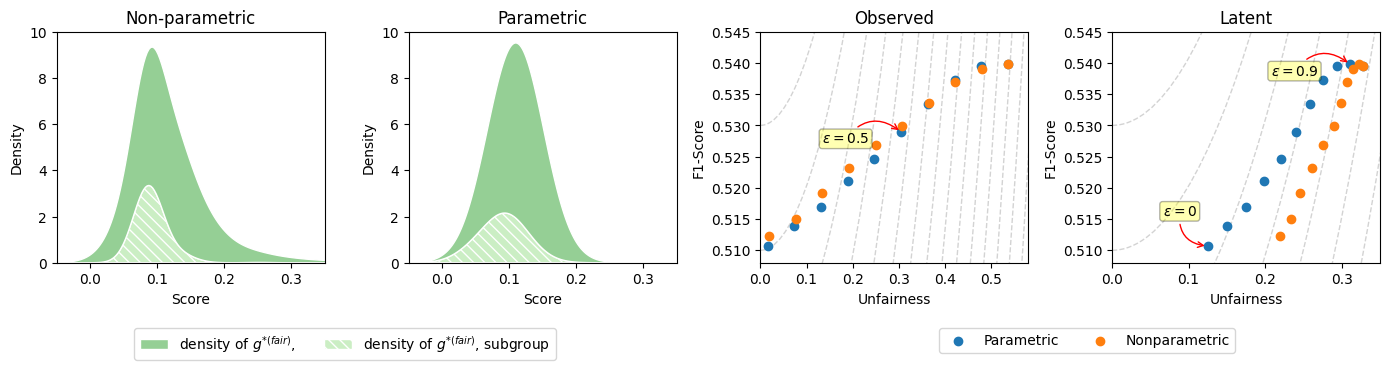

In [34]:
groups = [r"density of $g^{*(fair)}$"]
subgroups = ['', 'subgroup']
parametric = ['Non-parametric', 'Parametric']

data_intersectional['subgroup'] = data_intersectional['subgroup'].fillna("")

fig, axs = plt.subplots(ncols=4, figsize=(14,3.2666666666666666), sharex=False, sharey=False)
colors = [[plt.cm.tab20.colors[i:i + 2] for i in range(0, 3 * 2, 2)][2]]
hatches = ['', '\\\\\\']
ax_counter = 0
for i, (ax, param) in enumerate(zip(axs, parametric)):
    
    if i < 2:
        handles = []
        for group, palette in zip(groups, colors):
            sns.kdeplot(data=data_intersectional[(data_intersectional['parametric'] == param) & (data_intersectional['group'] == group)],
                        x='value', hue='subgroup', hue_order=subgroups, multiple='stack', palette=palette, ax=ax, alpha=0.5, fill=True, bw_adjust=3, lw=1, edgecolor="white")
            for h, gr, hatch in zip(ax.legend_.legend_handles, subgroups, hatches):
                #h.set_label(f'{group}, {age}')
                h.set_label(f'{group}, {gr}')
                h.set_hatch(hatch)
                handles.append(h)
        ax.legend_.remove() # remove the automatic legends
        ax.set_title(f'{param}')
        for collection, hatch in zip(ax.collections[::-1], hatches * len(groups)):
            collection.set_hatch(hatch)
      
        ax.set_xlim(-0.05, 0.28)
        ax.set_ylabel("")
        ax.set_xlabel("")

        ax_counter += 1


for r in np.arange(0.05, 2, 0.02):
    axs[2].add_patch(plt.Circle((0, 1), r, linestyle = "--", color='lightgray', fill=False, alpha=1))

axs[2].set_xlim([0,0.58])
axs[2].set_ylim([0.500, 0.545])

axs[2].set_title('Observed')

axs[2].scatter(df_epsiolon.unfairness_param,
    df_epsiolon.qrisk_param, 
        label='Parametric')

axs[2].scatter(df_epsiolon.unfairness_nonparam,
        df_epsiolon.qrisk_nonparam, 
        label='Nonparametric')

axs[2].legend()


for r in np.arange(0.05, 2, 0.02):
    axs[3].add_patch(plt.Circle((0, 1), r, linestyle = "--", color='lightgray', fill=False, alpha=1))

axs[3].scatter(df_epsiolon.unfairness_unobs_param,
    df_epsiolon.qrisk_param, 
        )

axs[3].scatter(df_epsiolon.unfairness_unobs_nonparam,
        df_epsiolon.qrisk_nonparam)

axs[3].set_xlim([0,0.58])
axs[3].set_ylim([0.510, 0.545])

axs[3].set_title('Latent')

axs[0].set_xlim([-0.05, 0.35])
axs[1].set_xlim([-0.05, 0.35])

axs[0].set_ylim([0, 10])
axs[1].set_ylim([0, 10])

axs[3].set_xlim([0,0.35])
axs[3].set_ylim([0.508, 0.545])
axs[2].set_ylim([0.508, 0.545])


axs[3].annotate(r'$\epsilon=0$', xy=(df_epsiolon.unfairness_unobs_param[0], df_epsiolon.qrisk_param[0]), xytext=(-20,20), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='red'))

axs[3].annotate(r'$\epsilon=0.9$', xy=(df_epsiolon.unfairness_unobs_param[9], df_epsiolon.qrisk_param[9]), xytext=(-40,-10), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.5', 
                            color='red'))


axs[2].annotate(r'$\epsilon=0.5$', xy=(df_epsiolon.unfairness_param[5], df_epsiolon.qrisk_param[5]), xytext=(-40,-10), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.5', 
                            color='red'))

fig.legend(handles=axs[2].legend_.legend_handles,
        loc='upper center',
        bbox_to_anchor=(.78, 0), ncol=3, fancybox=True)

axs[2].legend_.remove()


axs[0].set_ylabel('Density')
axs[1].set_ylabel('Density')
axs[2].set_ylabel('F1-Score')
axs[3].set_ylabel('F1-Score')   

axs[0].set_xlabel('Score')
axs[1].set_xlabel('Score')
axs[2].set_xlabel('Unfairness')
axs[3].set_xlabel('Unfairness')

fig.legend(handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.25, 0), ncol=3, fancybox=True) # bbox_to_anchor=(0.5, -0.05)
plt.tight_layout()
#plt.savefig("intersectional_real_data_new.png", bbox_inches = 'tight')
plt.show()